## 모델 학습

In [ ]:
# 한글 폰트 설정
# !sudo apt-get install -y fonts-nanum > /dev/null
# !sudo fc-cache -fv > /dev/null
# !rm ~/.cache/matplotlib -rf > /dev/null

# 런타임 재시작

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/mnt/')

Mounted at /content/mnt/


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lightgbm import LGBMClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_validate

In [ ]:
# train = pd.read_csv('/content/mnt/MyDrive/Project/data/prep_train.csv', encoding='utf-8')
# test = pd.read_csv('/content/mnt/MyDrive/Project/data/prep_test.csv', encoding='utf-8')
train = pd.read_csv('./prep_train.csv', encoding = 'utf-8')
test = pd.read_csv('./prep_test.csv', encoding = 'utf-8')

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        26457 non-null  int64  
 1   car                           26457 non-null  int64  
 2   reality                       26457 non-null  int64  
 3   child_num                     26457 non-null  int64  
 4   income_total                  26457 non-null  float64
 5   income_type                   26457 non-null  int64  
 6   edu_type                      26457 non-null  int64  
 7   family_type                   26457 non-null  int64  
 8   house_type                    26457 non-null  int64  
 9   DAYS_BIRTH                    26457 non-null  int64  
 10  DAYS_EMPLOYED                 26457 non-null  int64  
 11  family_size                   26457 non-null  float64
 12  begin_month                   26457 non-null  float64
 13  c

In [ ]:
train.std()

gender                              0.470619
car                                 0.485333
reality                             0.468784
child_num                           0.711671
income_total                        0.480820
income_type                         0.978260
edu_type                            0.558390
family_type                         0.872751
house_type                          0.587750
DAYS_BIRTH                       4201.589022
DAYS_EMPLOYED                    2370.140530
family_size                         0.916717
begin_month                        16.559550
credit                              0.702283
before_EMPLOYED                  4865.604165
income_total_befofeEMP_ratio       10.349769
before_EMPLOYED_m                   3.404029
before_EMPLOYED_w                   1.119270
Age                                11.512586
DAYS_BIRTH_m                        3.447657
DAYS_BIRTH_w                        1.113816
EMPLOYED                            6.581320
DAYS_EMPLO

In [ ]:
from sklearn.preprocessing import StandardScaler
numerical_feats = train.dtypes[train.dtypes != "object"].index.tolist()
numerical_feats.remove('credit')
numerical_feats.remove('income_total') # 이미 로그변환을 진행한 income_total을 제외한 나머지 numeric 컬럼 정규화
scaler = StandardScaler()
train[numerical_feats] = scaler.fit_transform(train[numerical_feats])
test[numerical_feats] = scaler.transform(test[numerical_feats])

- 데이터 분리

In [ ]:
from sklearn.model_selection import train_test_split
X = train.drop('credit', axis=1)
y = train.credit
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=2021)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((18519, 26), (7938, 26), (18519,), (7938,))

### 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression() # random_state=42
model_logit.fit(X_train, y_train)

LogisticRegression()

In [ ]:
model_logit.score(X_train, y_train), model_logit.score(X_test, y_test) 

(0.6446892380798099, 0.6436130007558579)

In [ ]:
# 예측
y_pred = model_logit.predict(X_test)

[[   0    9  958]
 [   0   25 1855]
 [   0    7 5084]]


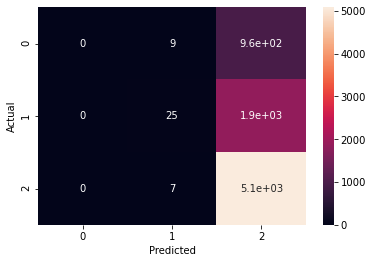

In [ ]:
# 혼합행렬
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_lr))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# 모형 성능 평가 - 평가지표 계산
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       967
         1.0       0.61      0.01      0.03      1880
         2.0       0.64      1.00      0.78      5091

    accuracy                           0.64      7938
   macro avg       0.42      0.34      0.27      7938
weighted avg       0.56      0.64      0.51      7938



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, {'n_neighbors': [1,3,5,7]}, n_jobs=-1, cv=7, scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 3, 5, 7]}, scoring='accuracy')

In [ ]:
grid_search.best_params_

{'n_neighbors': 7}

In [ ]:
knn_best = grid_search.best_estimator_

In [ ]:
y_pred = knn_best.predict(X_test)

[[ 179  151  637]
 [  91  610 1179]
 [ 249  590 4252]]


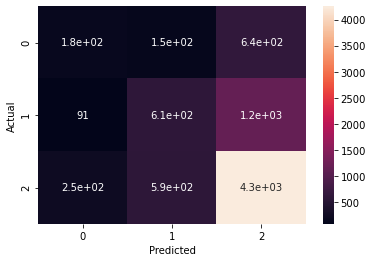

In [ ]:
# 혼합행렬
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.34      0.19      0.24       967
         1.0       0.45      0.32      0.38      1880
         2.0       0.70      0.84      0.76      5091

    accuracy                           0.64      7938
   macro avg       0.50      0.45      0.46      7938
weighted avg       0.60      0.64      0.61      7938



### SVM

In [ ]:
from sklearn import svm

svm_model = svm.SVC(kernel='rbf') # random_state=42

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(svm_model, {'C': [1,2,3,4,5]}, n_jobs=-1, cv=7, scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=7, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 3, 4, 5]}, scoring='accuracy')

In [ ]:
grid_search.best_params_

{'C': 5}

In [ ]:
svm_best = grid_search.best_estimator_

In [ ]:
y_pred = svm_best.predict(X_test)

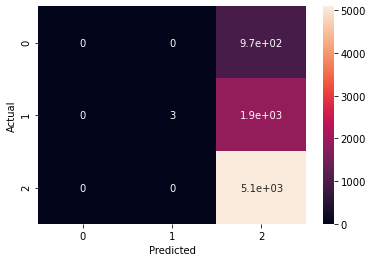

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       967
         1.0       1.00      0.00      0.00      1880
         2.0       0.64      1.00      0.78      5091

    accuracy                           0.64      7938
   macro avg       0.55      0.33      0.26      7938
weighted avg       0.65      0.64      0.50      7938



### 결정트리

In [ ]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [ ]:
# 예측
y_pred = model_logit.predict(X_test)

[[   0    9  958]
 [   0   25 1855]
 [   0    7 5084]]


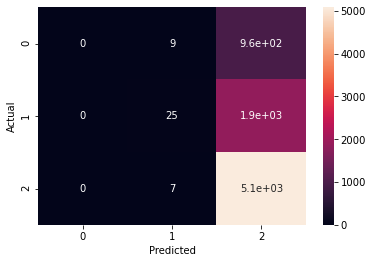

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       967
         1.0       0.61      0.01      0.03      1880
         2.0       0.64      1.00      0.78      5091

    accuracy                           0.64      7938
   macro avg       0.42      0.34      0.27      7938
weighted avg       0.56      0.64      0.51      7938



In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# plt.figure(figsize=(10,7))
# plot_tree(dt)
# plt.show()

In [ ]:
# 가지치기
dt = DecisionTreeClassifier(max_depth=3, random_state=42) 
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=42)

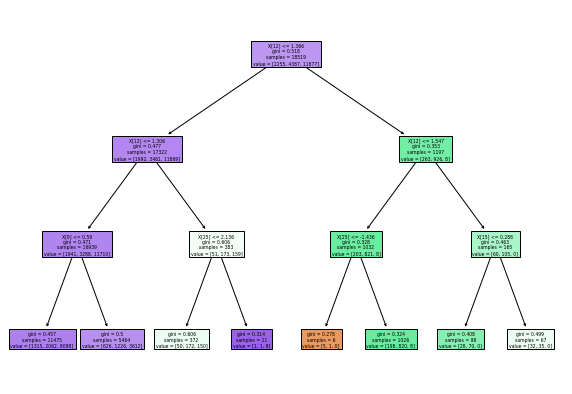

In [ ]:
plt.figure(figsize=(10,7))
plot_tree(dt, filled=True)
plt.show()

In [ ]:
print(dt.feature_importances_)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.01502085 0.         0.
 0.97369328 0.         0.         0.00298041 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.00830546]


gender: 0.000
car: 0.000
reality: 0.000
child_num: 0.000
income_total: 0.000
income_type: 0.000
edu_type: 0.000
family_type: 0.000
house_type: 0.000
DAYS_BIRTH: 0.015
DAYS_EMPLOYED: 0.000
family_size: 0.000
begin_month: 0.974
before_EMPLOYED: 0.000
income_total_befofeEMP_ratio: 0.000
before_EMPLOYED_m: 0.003
before_EMPLOYED_w: 0.000
Age: 0.000
DAYS_BIRTH_m: 0.000
DAYS_BIRTH_w: 0.000
EMPLOYED: 0.000
DAYS_EMPLOYED_m: 0.000
DAYS_EMPLOYED_w: 0.000
ability: 0.000
income_mean: 0.000
ID: 0.008


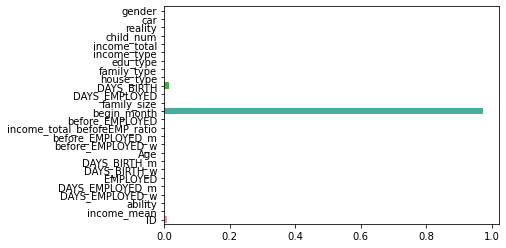

In [ ]:
# feature 별 feature importance 매핑
feature_names = X.columns.tolist()

# feature 별 feature importance 매핑
for name, value in zip(feature_names, dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

# feature importance 시각화
sns.barplot(x=dt.feature_importances_, y=feature_names)
plt.show()

In [ ]:
y_pred = dt.predict(X_test)

[[   1  135  831]
 [   1  462 1417]
 [   0   92 4999]]


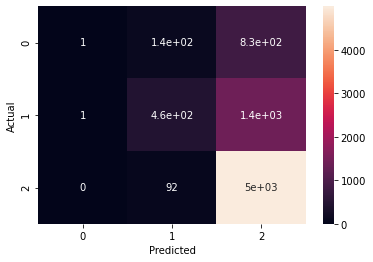

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.50      0.00      0.00       967
         1.0       0.67      0.25      0.36      1880
         2.0       0.69      0.98      0.81      5091

    accuracy                           0.69      7938
   macro avg       0.62      0.41      0.39      7938
weighted avg       0.66      0.69      0.61      7938



### 랜덤 포레스트

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
start = time.time() # 시작 시간

# 랜덤 포레스트의 parameter 범위 정의
RF_params = {
    'n_estimators' : [50, 100, 200, 300, 1000],#[50, 100, 150, 200, 300, 500, 1000],
    'max_features' : ['auot', 'sqrt'],
    'max_depth' : [1, 2, 3, 5, 6, 10],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 3, 5, 10]
}

# GridSearchCV를 이용
model_RF = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1)
model_RF.fit(X_train, y_train)
print(model_RF.best_params_)
RF_best = grid_search.best_estimator_
y_pred = RF_best.predict(X_test)

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

{'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1000}
걸린시간 : 216.433초


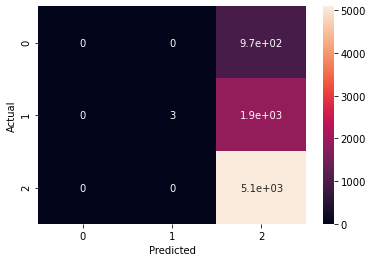

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       967
         1.0       1.00      0.00      0.00      1880
         2.0       0.64      1.00      0.78      5091

    accuracy                           0.64      7938
   macro avg       0.55      0.33      0.26      7938
weighted avg       0.65      0.64      0.50      7938



### XGBoost

In [ ]:
from xgboost import XGBClassifier
start = time.time()

XGB_params = {
    'min_child_weight': [1,3, 5,10],
    'gamma': [0.3,0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5,7,10]}

model_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid=XGB_params, n_jobs=-1)
model_xgb.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
print(model_xgb.best_params_)
xgb_best = grid_search.best_estimator_
y_pred = xgb_best.predict(X_test)

print(f'{np.round(time.time()-start, 3)}초') # 걸린시간

[10:17:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'colsample_bytree': 0.6, 'gamma': 1.5, 'max_depth': 10, 'min_child_weight': 5, 'subsample': 1.0}
2118.497초


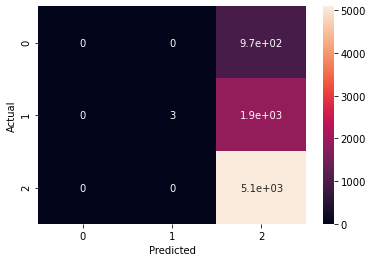

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       967
         1.0       1.00      0.00      0.00      1880
         2.0       0.64      1.00      0.78      5091

    accuracy                           0.64      7938
   macro avg       0.55      0.33      0.26      7938
weighted avg       0.65      0.64      0.50      7938



## 변수축소 - 모델학습 및 평가

In [ ]:
# 변수축소
X_train = X_train[['DAYS_BIRTH', 'begin_month', 'before_EMPLOYED_w', 'ability', 'ID']]
X_test = X_test[['DAYS_BIRTH', 'begin_month', 'before_EMPLOYED_w', 'ability', 'ID']]

### 로지스틱 회귀

In [ ]:
from sklearn.linear_model import LogisticRegression
model_logit = LogisticRegression() # random_state=42
model_logit.fit(X_train, y_train)

In [ ]:
model_logit.score(X_train, y_train), model_logit.score(X_test, y_test) 

In [ ]:
# 예측
y_pred = model_logit.predict(X_test)

In [ ]:
# 혼합행렬
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
# 모형 성능 평가 - 평가지표 계산
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, {'n_neighbors': [1,3,5,7]}, n_jobs=-1, cv=7, scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
knn_best = grid_search.best_estimator_

In [ ]:
y_pred = knn_best.predict(X_test)

In [ ]:
# 혼합행렬
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

### SVM

In [ ]:
from sklearn import svm

svm_model = svm.SVC(kernel='rbf') # random_state=42

In [ ]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(svm_model, {'C': [1,2,3,4,5]}, n_jobs=-1, cv=7, scoring='accuracy')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
svm_best = grid_search.best_estimator_

In [ ]:
y_pred = svm_best.predict(X_test)

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

### 결정트리

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier

# 가지치기
dt = DecisionTreeClassifier(max_depth=3, random_state=42) 
dt.fit(X_train, y_train)
print(dt.feature_importances_)

In [ ]:
plt.figure(figsize=(10,7))
plot_tree(dt, filled=True)
plt.show()

In [ ]:
print(dt.feature_importances_)

In [ ]:
# feature 별 feature importance 매핑
feature_names = X.columns.tolist()

# feature 별 feature importance 매핑
for name, value in zip(feature_names, dt.feature_importances_):
    print('{0}: {1:.3f}'.format(name, value))

# feature importance 시각화
sns.barplot(x=dt.feature_importances_, y=feature_names)
plt.show()

In [ ]:
y_pred = dt.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

### 랜덤 포레스트

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
start = time.time() # 시작 시간

# 랜덤 포레스트의 parameter 범위 정의
RF_params = {
    'n_estimators' : [50, 100, 150, 200, 300, 500, 1000],
    'max_features' : ['auot', 'sqrt'],
    'max_depth' : [1, 2, 3, 5, 6, 10],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 3, 5, 10]
}

# GridSearchCV를 이용
model_RF = GridSearchCV(RandomForestRegressor(random_state=42), param_grid=RF_params, n_jobs=-1)
model_RF.fit(X_train, y_train)
print(model_RF.best_params_)
RF_best = grid_search.best_estimator_
y_pred = RF_best.predict(X_test)

print(f"걸린시간 : {np.round(time.time() - start,3)}초") # 현재시간 – 시작시간(단위 초)

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

### XGBoost

In [ ]:
from xgboost import XGBClassifier
start = time.time()

XGB_params = {
    'min_child_weight': [1,3, 5,10],
    'gamma': [0.3,0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3, 4, 5,7,10]}

model_xgb = GridSearchCV(XGBClassifier(random_state=42), param_grid=XGB_params, n_jobs=-1)
model_xgb.fit(X_train, y_train)
model_RF.fit(X_train, y_train)
print(model_xgb.best_params_)
xgb_best = grid_search.best_estimator_
y_pred = xgb_best.predict(X_test)

print(f'{np.round(time.time()-start, 3)}초') # 걸린시간

In [ ]:
confusion_matrix(y_test, y_pred)

sns.heatmap(confusion_matrix(y_test, y_pred), annot=True)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))